**环境搭建**

In [5]:
!nvidia-smi
import torch
import os
from ultralytics.models.yolo.detect.train import DetectionTrainer
from ultralytics import YOLO
# os.chdir(path='E://bmx/DyFilterAttack')

Sat Jun 14 14:44:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090      WDDM  |   00000000:01:00.0  On |                  Off |
|  0%   47C    P8             15W /  450W |     906MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**数据集准备**

关于数据集格式的说明：标签以 YOLO 格式导出，保存为 \*.txt 文件。

如果图像中没有目标对象，则不需要创建 \*.txt 文件。 \*.txt 文件的格式为每个目标对象一行，格式为 `[类别, x_center, y_center, 宽度, 高度]`。边界框的坐标是归一化的 `[x, y, w, h]` 格式（范围从 0 到 1）。

后面的代码是以像素为单位测量的，将 `x_center` 和 `宽度` 除以图像的宽度，将 `y_center` 和 `高度` 除以图像的高度。类别编号为从 0 开始的索引（即从 0 开始计数）。

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = dict(model="../models/yolov8-gtsrb.pt", data="./data.yaml")
trainer = DetectionTrainer(overrides=args)
trainer.setup_model()
trainer.set_model_attributes()
trainer.model.to(device=device)
trainer.model.eval()
detector = YOLO(model="../models/yolov8-gtsrb.pt")
detector.to(device=device, dtype=torch.float32).eval()

Ultralytics 8.3.119  Python-3.11.11 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: task=detect, mode=train, model=../models/yolov8-gtsrb.pt, data=./data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train201, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

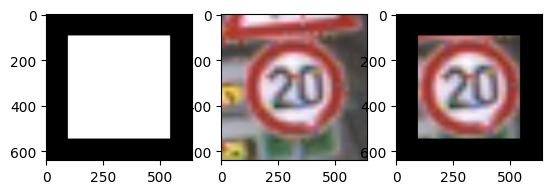

In [7]:
from DyFilterAttack.mask_attack.utils.CustomDataset import CustomDataset

images_dir_path = "../test/gtsrb_origin/0/images"
labels_dir_path = "../test/gtsrb_origin/0/labels"
# Initialize dataset


train_dataset = CustomDataset(images_dir_path = images_dir_path, 
                              labels_dir_path = labels_dir_path,
                              image_width=640,
                              image_height=640)

sample_data = train_dataset[0]

import matplotlib.pyplot as plt

plt.subplot(131)
plt.imshow(sample_data["mask"][0, :, :], cmap='gray')
# img.size()
plt.subplot(132)
masked_img = sample_data["image"]
plt.imshow(masked_img.permute(1, 2, 0))
plt.subplot(133)
masked_img = sample_data["image"] * sample_data["mask"]
plt.imshow(masked_img.permute(1, 2, 0))
plt.show()

**批量攻击**

In [ ]:
import os
from DyFilterAttack.mask_attack.utils.datasets.gtsrb import classes_batch_attack_gtsrb
from DyFilterAttack.mask_attack.utils.datasets.cctsdb import batch_attack_cctsdb

batch_attack_cctsdb(
    trainer=trainer, 
    classes_name=[], 
    batch_size=16,
    test_classes_root='../../../CCTSDB', 
    output_root='result/cctsdb', 
    method="masked_pgd", 
    epsilon=0.05, 
    alpha=0.0005,
    num_iter=100
)

Can not Find Dir: ../../CCTSDB\images of ../../CCTSDB\labels


In [ ]:
classes_batch_attack_gtsrb(
    trainer=trainer, 
    classes_name=['0'], 
    batch_size=16,
    test_classes_root='../../../gtsrb_classes_attacked_test/origin', 
    output_root="result/gtsrb", 
    method="masked_pgd", 
    epsilon=0.05, 
    alpha=0.0005,
    num_iter=100
)

Processing Batches in masked_pgd-epsilon-0.0500-alpha-0.0005-num_iter-100.0000:  25%|██▌       | 1/4 [00:12<00:37, 12.62s/it]


KeyboardInterrupt: 

**攻击结果可视化**

In [ ]:
from DyFilterAttack.mask_attack.utils.CustomDataset import CustomDataset
from DyFilterAttack.mask_attack.utils.plot import visualize_attack_result

origin_dataset = CustomDataset(images_dir_path = "../datasets/gtsrb_origin/0/images", 
                              labels_dir_path = "../datasets/gtsrb_origin/0/labels",
                              image_width=640,
                              image_height=640)
attacked_dataset = CustomDataset(images_dir_path = "../datasets/gtsrb_attack/0/images",
                              labels_dir_path = "../datasets/gtsrb_attack/0/labels",
                              image_width=640,
                              image_height=640)
visualize_attack_result(detector, origin_dataset, attacked_dataset)

**攻击效果评估**

In [ ]:
from mask_attack.utils.datasets.gtsrb import ValGTSRB
val_gtsrb = ValGTSRB(detector, attack_result_root = "../../gtsrb_no_classes_attacked_test", origin_yaml_path='./gtsrb.yaml')
val_gtsrb.show_method()

NameError: name 'detector' is not defined

In [ ]:
val_metrics = val_gtsrb.single_param_val(method='origin')

In [ ]:
val_metrics = val_gtsrb.single_param_val(method='fgsm', epsilon=0.03)

In [ ]:
val_metrics = val_gtsrb.single_param_val(method='masked_fgsm', epsilon=0.03)

In [ ]:
val_metrics = val_gtsrb.single_param_val(method='masked_fgsm', epsilon=0.05)

In [ ]:
val_metrics = val_gtsrb.single_param_val(method='masked_pgd', epsilon=0.05, alpha=0.0005, num_iter=100)

In [ ]:
val_metrics = val_gtsrb.single_param_val(method='masked_pgd', epsilon=0.03, alpha=0.0003, num_iter=100)

In [ ]:
val_metrics = val_gtsrb.single_param_val(method='masked_pgd', epsilon=0.02, alpha=0.0002, num_iter=100)

In [ ]:
val_metrics = val_gtsrb.single_param_val(method='masked_pgd', epsilon=0.02, alpha=0.0002, num_iter=150)

In [ ]:
val_metrics = val_gtsrb.single_param_val(method='masked_pgd', epsilon=0.01, alpha=0.0001, num_iter=100)

In [ ]:
val_metrics = val_gtsrb.single_param_val(method='masked_pgd', epsilon=0.005, alpha=0.0001, num_iter=100)

In [ ]:
val_metrics = val_gtsrb.single_param_val(method='masked_pgd', epsilon=0.005, alpha=0.0001, num_iter=150)